In [1]:
import os
import sys
import lmfit as lm
import logging
# import glob
# import time
# import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Custom packages
import iXAtom_Class_Physics       as iXC_Physics
import iXAtom_Class_RunParameters as iXC_RunPars
import iXAtom_Class_Detector      as iXC_Detect
import iXAtom_Class_Ramsey        as iXC_Ramsey
import iXAtom_Utilities           as iXUtils

# For inline plots
%matplotlib inline
# Reload IPython extension 'autoreload'
%reload_ext autoreload
# autoreload: Reload all modules (except those excluded by %aimport) automatically now
# autoreload 0: Disable automatic reloading of modules
# autoreload 1: Reload all modules imported with %aimport every time before executing
# autoreload 2: Reload all modules (except those excluded by %aimport) every time before executing
%autoreload 1

%aimport iXAtom_Class_Physics
%aimport iXAtom_Class_RunParameters
%aimport iXAtom_Class_Detector
%aimport iXAtom_Class_Ramsey
%aimport iXAtom_Utilities

logging.disable(level=logging.NOTSET)

iXUtils.SetDefaultPlotOptions()

In [11]:
# RootDir = 'C:\\iXAtom Desktop\\Data 2020'
RootDir = 'C:\\Bryns Goodies\\Work-iXAtom\\Data 2020'
Date    = {'Month': 'October', 'Day': 29}
WorkDir = os.path.join(RootDir, Date['Month'], '{:02d}'.format(Date['Day']))
Folder  = 'Rabi'
RunNum  = 1

RunPars = iXC_RunPars.RunParameters(WorkDir, Folder, RunNum)
RunPars.LoadRunParameters()

Physics = iXC_Physics.Physics(RunPars)
iaxList = RunPars.iaxList
ikList  = RunPars.ikList
keff    = RunPars.keff
gLocal  = RunPars.gLocal

def Gauss(r, A, r0, sigma):
    return A*np.exp(-2*((r-r0)/sigma)**2)

GModel = lm.Model(Gauss)

pd.DataFrame(RunPars.__dict__.items())

,0,1
0,SoftwareVersion,3.4
1,Run,1
2,DataType,Rabi
3,TrackProtocol,Two-Point kInterlaced
4,TrackMode,"Closed Loop, RT Chirp"
...,...,...
102,nk,2
103,nax,3
104,FilePrefix,Rabi
105,AxisFileLabels,"[X, Y, Z]"


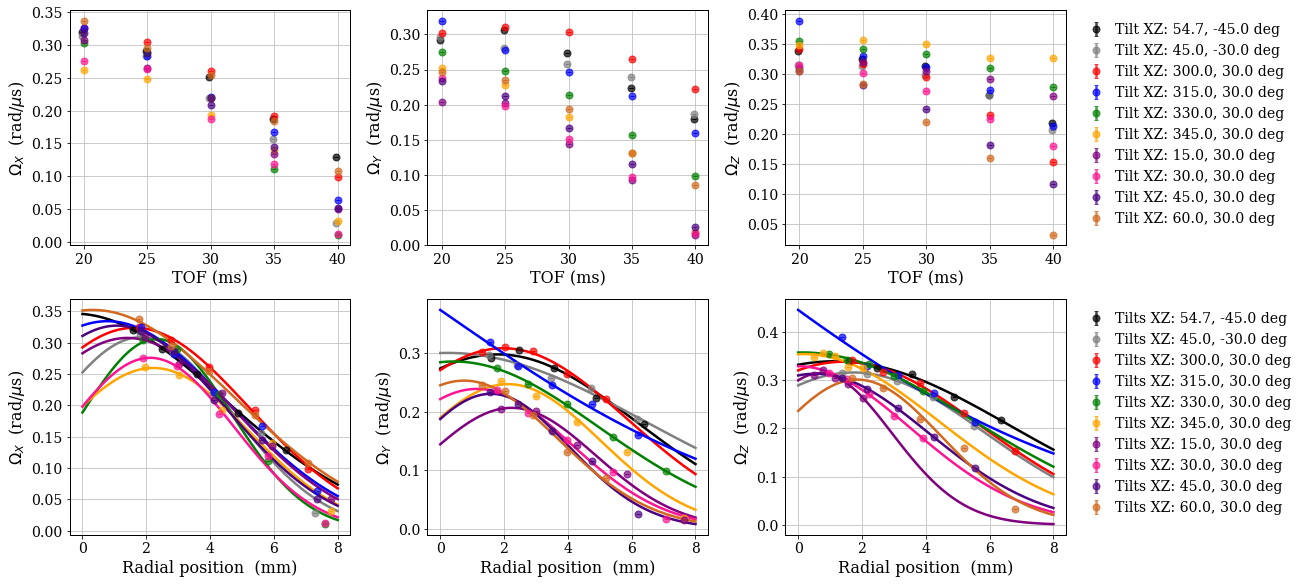

In [27]:
#========================================================================================= 
#  Plot analysis summary results for specific runs on specific days
#=========================================================================================
## Set plot options
plt.rc('font', size=14, family='serif')
plt.rc('axes', titlesize=12, labelsize=16, edgecolor='black', linewidth=1)
plt.rc('lines', linewidth=2.5, markersize=14)
plt.rc('legend', fontsize=14, frameon=False, handletextpad=0.4)

DateList = [
    {'Month': 'October', 'Day': 19}, {'Month': 'October', 'Day': 26},
    {'Month': 'October', 'Day': 29}, {'Month': 'October', 'Day': 29}, {'Month': 'October', 'Day': 29},
    {'Month': 'October', 'Day': 29}, {'Month': 'October', 'Day': 29}, 
    {'Month': 'October', 'Day': 29}, {'Month': 'October', 'Day': 29}, {'Month': 'October', 'Day': 29}]
RunLists = [
    [1,5], [1,5],
    [2,6], [7,11], [12,16],
    [17,21], [22,26],
    [27,31], [32,36], [37,41]]
nList    = len(RunLists)
TiltX    = np.zeros(nList)
TiltZ    = np.zeros(nList)
Colors   = [
    'black', 'gray',
    'red', 'blue', 'green',
    'orange', 'purple',
    'deeppink', 'indigo', 'chocolate']

RawDF = pd.DataFrame([])
FitDF = [pd.DataFrame([]) for iax in range(3)]

nRows, nCols = (2,3)
fig, axs = plt.subplots(nrows=nRows, ncols=nCols, figsize=(nCols*6,nRows*4), constrained_layout=True)

for r in range(nList):
    RunList = RunLists[r]
    WorkDir = os.path.join(RootDir, DateList[r]['Month'], '{:02d}'.format(DateList[r]['Day']))
    RunPars = iXC_RunPars.RunParameters(WorkDir, Folder, RunList[0])
    RunPars.LoadRunParameters()

    Physics = iXC_Physics.Physics(RunPars)

    SummaryFolder     = os.path.join(WorkDir, 'PostProcessed', Folder)
    SummaryFilePrefix = Folder + '-Runs{:02d}-{:02d}-AnalysisSummary-'.format(min(RunList), max(RunList))
    SummaryFilePaths  = [os.path.join(SummaryFolder, SummaryFilePrefix + RunPars.AxisFileLabels[iax][0] + '.txt') for iax in range(3)]

    SummaryDF = [pd.DataFrame([]) for iax in range(3)]

    for iax in iaxList:
        if os.path.exists(SummaryFilePaths[iax]):
            SummaryDF[iax] = pd.read_csv(SummaryFilePaths[iax], sep='\t')
        else:
            print('Summary file not found: {}'.format(SummaryFilePaths[iax]))

    ## Default plot options
    PlotOpts = {'Color': Colors[r], 'Linestyle': 'None', 'Marker': '.',
        'Title': 'None', 'xLabel': 'None', 'yLabel': 'None',
        'LegLabel': 'None', 'Legend': False, 'LegLocation': 'best'}

    TOF   = SummaryDF[0]['RamanTOF'].to_numpy()
    TiltX[r] = Physics.TiltX
    TiltZ[r] = Physics.TiltZ
    nData = len(TOF)
    r0    = np.zeros(3)
    v0    = np.zeros(3)
    rCOM  = np.zeros((3,nData))
    
    d1 = {'thetaX': Physics.thetaX*180/np.pi, 'thetaZ': Physics.thetaZ*180/np.pi}

    for iTOF in range(nData):
        rCOM[:,iTOF] = Physics.ClassicalTrajectory(0.,r0,v0,TOF[iTOF])[0]

        ## Update raw data frame
        d2 = {'TOF': TOF[iTOF],
            'OmegaX': SummaryDF[0]['Omega'].iloc[iTOF], 'dOmegaX': SummaryDF[0]['Omega_Err'].iloc[iTOF],
            'OmegaY': SummaryDF[1]['Omega'].iloc[iTOF], 'dOmegaY': SummaryDF[1]['Omega_Err'].iloc[iTOF],
            'OmegaZ': SummaryDF[2]['Omega'].iloc[iTOF], 'dOmegaZ': SummaryDF[2]['Omega_Err'].iloc[iTOF]}
        d2.update(d1)
        RawDF = RawDF.append(d2, ignore_index=True)

    for iax in iaxList:
        if iax == 0:
            rBeam = np.sqrt(rCOM[1]**2 + rCOM[2]**2)
        elif iax == 1:
            rBeam = np.sqrt(rCOM[2]**2 + rCOM[0]**2)
        else:
            rBeam = np.sqrt(rCOM[0]**2 + rCOM[1]**2)

        PlotOpts['xLabel']   = 'TOF (ms)'
        PlotOpts['yLabel']   = r'$\Omega_'+RunPars.AxisFileLabels[iax][0]+'$  (rad/$\mu$s)'
        PlotOpts['LegLabel'] = 'Tilt XZ: {:.1f}, {:.1f} deg'.format(TiltX[r], TiltZ[r])
        Omega  = SummaryDF[iax]['Omega'].to_numpy()
        dOmega = SummaryDF[iax]['Omega_Err'].to_numpy()
        iXUtils.CustomPlot(axs[0,iax], PlotOpts, TOF*1.E3, Omega, 0*dOmega)

        PlotOpts['xLabel']   = 'Radial position  (mm)'
        PlotOpts['LegLabel'] = 'Tilts XZ: {:.1f}, {:.1f} deg'.format(TiltX[r], TiltZ[r])
        # iXUtils.CustomPlot(axs[1,iax], PlotOpts, rCOM[iax]*1.E3, Omega, 0*dOmega)
        iXUtils.CustomPlot(axs[1,iax], PlotOpts, rBeam*1.E3, Omega, 0*dOmega)

        ## Gaussian fit
        result = GModel.fit(Omega, r=rBeam*1.E3, A=0.3, r0=1., sigma=9.)
        d1.update(result.best_values)
        d1.update({'dA': result.params['A'].stderr, 'dr0': result.params['r0'].stderr, 'dsigma': result.params['sigma'].stderr})

        FitDF[iax] = FitDF[iax].append(d1, ignore_index=True)

        PlotOpts['Linestyle'] = '-'
        PlotOpts['Marker']    = 'None'
        PlotOpts['LegLabel']  = None
        rFit = np.linspace(0.,8.,101)
        iXUtils.CustomPlot(axs[1,iax], PlotOpts, rFit, result.eval(r=rFit))
        PlotOpts['Linestyle'] = 'None'
        PlotOpts['Marker']    = '.'

        if iax == 2:
            axs[0,iax].legend(loc='upper left', bbox_to_anchor=(1.01,1.0))
            axs[1,iax].legend(loc='upper left', bbox_to_anchor=(1.01,1.0))

    # plotPath = 'C:\\Bryns Goodies\\Test.pdf'
    # plt.savefig(plotPath, dpi=150)
    
    # print('-------- Tilt X = {:.1f} deg --------'.format(TiltX[r]))
    # print('Slope  = ({:.4f} +/- {:.4f}) mG/mm'.format(pOpt[0]*1.E3, pErr[0]*1.E3))
    # print('Offset = ({:.6f} +/- {:.6f}) G'.format(pOpt[1], pErr[1]))

plt.show()

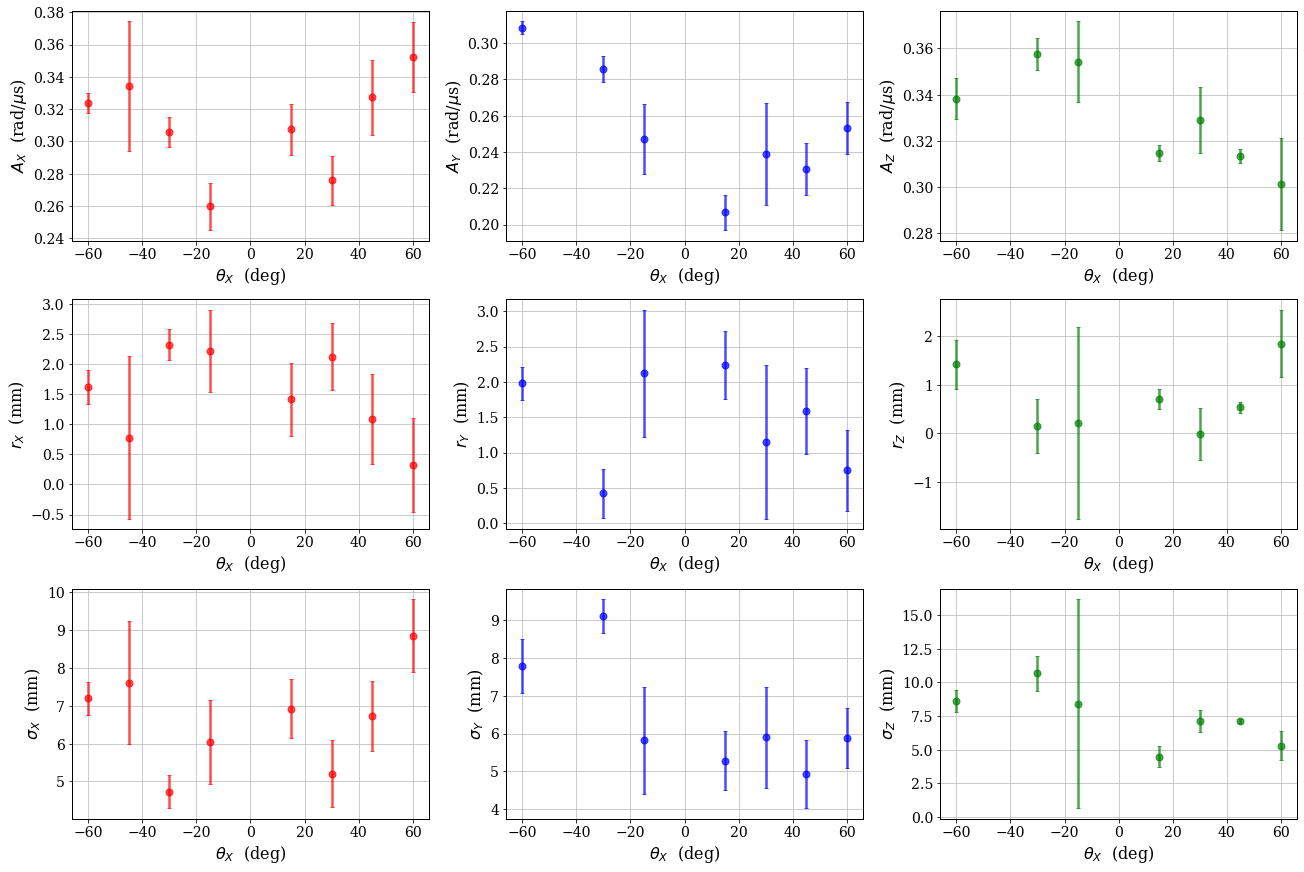

In [36]:
nRows, nCols = (3,3)
fig, axs = plt.subplots(nrows=nRows, ncols=nCols, figsize=(nCols*6,nRows*4), constrained_layout=True)

## Default plot options
PlotOpts = {'Color': 'red', 'Linestyle': 'None', 'Marker': '.',
    'Title': 'None', 'xLabel': 'None', 'yLabel': 'None',
    'LegLabel': 'None', 'Legend': False, 'LegLocation': 'best'}

for iax in iaxList:
    PlotOpts['Color']  = Colors[iax+2]
    PlotOpts['xLabel'] = r'$\theta_X$  (deg)'

    thz  = -30.
    mask1 = FitDF[iax]['thetaZ'] <= thz+0.1
    mask2 = FitDF[iax]['r0'] > -1.
    mask  = np.logical_and(mask1, mask2)
    
    thx = FitDF[iax].loc[mask, 'thetaX'].to_numpy()
    
    if iax == 0:
        s = 1.
    elif iax == 1:
        s = 1.#*np.abs(np.cos(thx*np.pi/180.))
    else: ## iax == 2:
        s = 1.#*np.abs(np.sin(thx*np.pi/180.))

    PlotOpts['yLabel'] = r'$A_'+RunPars.AxisFileLabels[iax][0]+'$  (rad/$\mu$s)'
    iXUtils.CustomPlot(axs[0,iax], PlotOpts, thx, FitDF[iax].loc[mask, 'A'].to_numpy(), FitDF[iax].loc[mask, 'dA'].to_numpy())

    PlotOpts['yLabel'] = r'$r_'+RunPars.AxisFileLabels[iax][0]+'$  (mm)'
    iXUtils.CustomPlot(axs[1,iax], PlotOpts, thx, FitDF[iax].loc[mask, 'r0'].to_numpy(), FitDF[iax].loc[mask, 'dr0'].to_numpy())

    PlotOpts['yLabel'] = r'$\sigma_'+RunPars.AxisFileLabels[iax][0]+'$  (mm)'
    iXUtils.CustomPlot(axs[2,iax], PlotOpts, thx, s*FitDF[iax].loc[mask, 'sigma'].to_numpy(), s*FitDF[iax].loc[mask, 'dsigma'].to_numpy())

plt.show()

In [28]:
FitDF[2][['thetaX', 'thetaZ', 'A', 'dA', 'r0', 'dr0', 'sigma', 'dsigma']].style.hide_index()

thetaX,thetaZ,A,dA,r0,dr0,sigma,dsigma
54.700000,45.000000,0.339223,0.008152,1.145252,0.683444,10.993624,1.372720
45.000000,30.000000,0.316012,0.001162,1.731680,0.091141,8.223928,0.223438
-60.000000,-30.000000,0.338293,0.008957,1.420922,0.502889,8.608921,0.842413
-45.000000,-30.000000,0.970528,3.990302,-14.418955,62.419069,23.115824,40.768666
-30.000000,-30.000000,0.357446,0.006871,0.141747,0.559853,10.657493,1.300785
-15.000000,-30.000000,0.354195,0.017490,0.212817,1.976840,8.395066,7.753710
15.000000,-30.000000,0.314602,0.003465,0.699200,0.208853,4.464280,0.786137
30.000000,-30.000000,0.329060,0.014278,-0.024775,0.538912,7.131368,0.811933
45.000000,-30.000000,0.313339,0.003033,0.534916,0.114048,7.126813,0.154548
60.000000,-30.000000,0.301216,0.019845,1.849703,0.697427,5.304837,1.087368


In [40]:
RawDF[['thetaX', 'thetaZ', 'TOF', 'OmegaX', 'dOmegaX', 'OmegaY', 'dOmegaY', 'OmegaZ', 'dOmegaZ']].style.hide_index()

thetaX,thetaZ,TOF,OmegaX,dOmegaX,OmegaY,dOmegaY,OmegaZ,dOmegaZ
54.700000,45.000000,0.019900,0.320622,0.002507,0.291259,0.001998,0.339011,0.002337
54.700000,45.000000,0.029900,0.250738,0.001496,0.274142,0.001965,0.313684,0.001752
54.700000,45.000000,0.039900,0.128791,0.009619,0.179052,0.003772,0.217344,0.001171
54.700000,45.000000,0.024900,0.290664,0.001243,0.305805,0.001879,0.325630,0.002461
54.700000,45.000000,0.034900,0.187087,0.002649,0.224150,0.001368,0.264876,0.001364
45.000000,30.000000,0.019900,0.313495,0.002556,0.296660,0.004074,0.315533,0.003208
45.000000,30.000000,0.024900,0.283772,0.002959,0.279956,0.004316,0.313448,0.001759
45.000000,30.000000,0.029900,0.219086,0.008353,0.258429,0.004361,0.298236,0.002000
45.000000,30.000000,0.034900,0.156236,0.026483,0.239824,0.048645,0.264820,0.003447
45.000000,30.000000,0.039900,0.028485,0.324748,0.187376,0.112447,0.205933,0.008868
